# Data Clustering

steps in this notebook

1. pull in the data

2. try a simple k means clustering

3. try an autoencoder with k means clustering

4. try and auto encoder with t-sne

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
img_md_subset = pd.read_csv('../../../Data/ifcb_ecotaxa_subset.csv')
img_md_subset = img_md_subset.drop('Unnamed: 0', 1)

pull out a random subset for speed

In [3]:
import glob, os

file_dir = '../../../Data/all_imagery/'

os.chdir(file_dir)
fn_list = []
for file in glob.glob("*.png"):
    fn_list.append(file)


In [4]:
fn_edit = [x[:-4] for x in fn_list]

In [5]:
img_subset_with_data = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(img_subset_with_data)

814838

In [16]:
df_sample = img_subset_with_data.sample(10000)
len(df_sample)

10000

These are major outliers so worth taking them out sometimes

In [17]:
df_sample = df_sample[df_sample.object_annotation_category != 'badfocus<artefact']
len(df_sample)

9050

Create class name dicts

In [18]:
class_id_list = [[x, i] for i, x in enumerate(list(df_sample.groupby('object_annotation_category')['object_id'].nunique().index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'Amphiprora',
 1: 'Chaetoceros<Mediophyceae',
 2: 'Ciliophora',
 3: 'Corethron',
 4: 'Cryptophyta',
 5: 'Cylindrotheca',
 6: 'Dictyochales',
 7: 'Dinophyceae',
 8: 'Eucampia',
 9: 'Fragilariopsis',
 10: 'Gymnodinium',
 11: 'Katodinium',
 12: 'Membraneis',
 13: 'Navicula',
 14: 'Nitzschia stellata',
 15: 'Odontella sp.',
 16: 'Phaeocystis',
 17: 'Polykrikos<Polykrikaceae',
 18: 'Proboscia sp.',
 19: 'Pseudo-Nitzschia chain',
 20: 'Pyramimonas',
 21: 'Rhizosolenia',
 22: 'Thalassiosira',
 23: 'bead',
 24: 'bubble',
 25: 'centric',
 26: 'centric 1 temp',
 27: 'centric 2 temp',
 28: 'centric 3 temp',
 29: 'centric 5 temp',
 30: 'centric 6 temp',
 31: 'centric 9 temp',
 32: 'detritus',
 33: 'multiple<other',
 34: 'part<other',
 35: 'pennate 1 temp',
 36: 'pennate 10 temp',
 37: 'pennate 11 temp',
 38: 'pennate 13 temp',
 39: 'pennate 2 temp',
 40: 'pennate 4 temp',
 41: 'pennate 7 temp',
 42: 'pennate<Bacillariophyta',
 43: 't002',
 44: 't003',
 45: 't007',
 46: 't008',
 47: 't009',
 48

Pull in all the data to memory

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []

for index, row in df_sample.iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images.append(image.img_to_array(img))
    try:
        labels.append(class_id_dict[row['object_annotation_category']])
    except KeyError: # this is to catch a couple nans
        print('found nan')
        labels.append(class_id_dict['part<other'])
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

found nan
found nan
found nan


((9050, 150, 150, 1), (9050,))

train it on this subset

K-Means

In [47]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

First flatten the data for scikit learn

In [48]:
x_minst = x_train.reshape((x_train.shape[0], -1))

x = images.reshape((images.shape[0], -1))
x.shape, x_minst.shape

((9050, 22500), (60000, 784))

visualize in PCA

In [49]:
X_reduced_minst = PCA(n_components=3).fit_transform(x_minst)
X_reduced_minst.shape

(60000, 3)

In [186]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(9031, 3)

In [50]:
df_minst = pd.DataFrame(np.array([X_reduced_minst[:, 0], X_reduced_minst[:, 1], X_reduced_minst[:, 2], 
                                  y_train]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_minst.head()

,pc1,pc2,pc3,label
0,123.934548,-312.678743,-24.494610,5.0
1,1011.720188,-294.854550,596.334097,0.0
2,-51.850093,392.171720,-188.507306,4.0
3,-799.126848,-607.214653,273.658732,1.0
4,-382.754921,730.558262,16.342057,9.0


In [146]:
df = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df.head()

,pc1,pc2,pc3,label
0,3603.6184,-1230.0912,989.39465,multiple<other
1,1538.9626,879.28156,956.7162,pennate 2 temp
2,-1005.1878,787.1251,-1506.3668,t002
3,1335.9458,-1157.7488,-445.8048,pennate 1 temp
4,3865.033,-561.2984,-706.2714,Pyramimonas


In [52]:
import plotly.express as px
fig = px.scatter_3d(df_minst.sample(1000), x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [147]:
import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [148]:
validated_samples = X_reduced[df_sample.object_annotation_status == 'validated']
val_labels = labels[df_sample.object_annotation_status == 'validated']
len(validated_samples)

248

In [149]:
df = pd.DataFrame(np.array([validated_samples[:, 0], validated_samples[:, 1], validated_samples[:, 2], [id_class_dict[x] for x in val_labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])

import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

convolutional autoencoder

In [39]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [22]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [41]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [77]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(150, 150, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [78]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [60]:
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

In [80]:
imags_norm = (images / 255.0 - 0.475) / 0.12

In [81]:
autoencoder.fit(imags_norm, imags_norm,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(images[:100], images[:100]))

Train on 9050 samples, validate on 100 samples
Epoch 1/50
9050/9050 [==============================] - 5s 589us/step - loss: -4.0182 - val_loss: -1886.1780
Epoch 2/50
9050/9050 [==============================] - 4s 455us/step - loss: -5.3511 - val_loss: -1886.2092
Epoch 3/50
9050/9050 [==============================] - 4s 458us/step - loss: -5.5801 - val_loss: -1886.3280
Epoch 4/50
9050/9050 [==============================] - 4s 456us/step - loss: -5.6752 - val_loss: -1886.4281
Epoch 5/50
9050/9050 [==============================] - 4s 461us/step - loss: -5.7158 - val_loss: -1886.4407
Epoch 6/50
9050/9050 [==============================] - 4s 460us/step - loss: -5.7457 - val_loss: -1886.4961
Epoch 7/50
9050/9050 [==============================] - 4s 458us/step - loss: -5.7701 - val_loss: -1886.4608
Epoch 8/50
9050/9050 [==============================] - 4s 458us/step - loss: -5.7835 - val_loss: -1886.1725
Epoch 9/50
9050/9050 [==============================] - 4s 460us/step - loss: -5.

KeyboardInterrupt: 

In [79]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

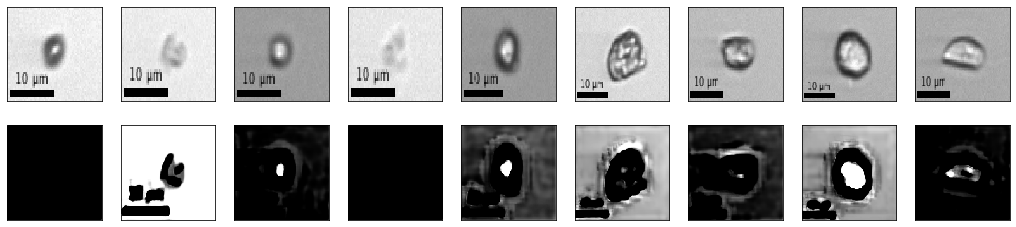

In [84]:
decoded_imgs = autoencoder.predict(imags_norm[:20])

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(imags_norm[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [85]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([imags_norm[:20]])
encoded_imgs.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`



(20, 19, 19, 8)

In [ ]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([x_test])
encoded_imgs.shape

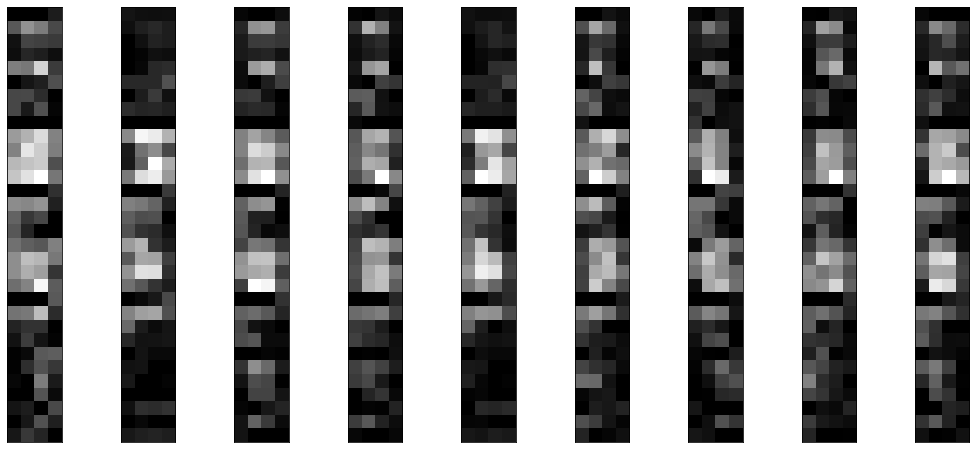

In [32]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

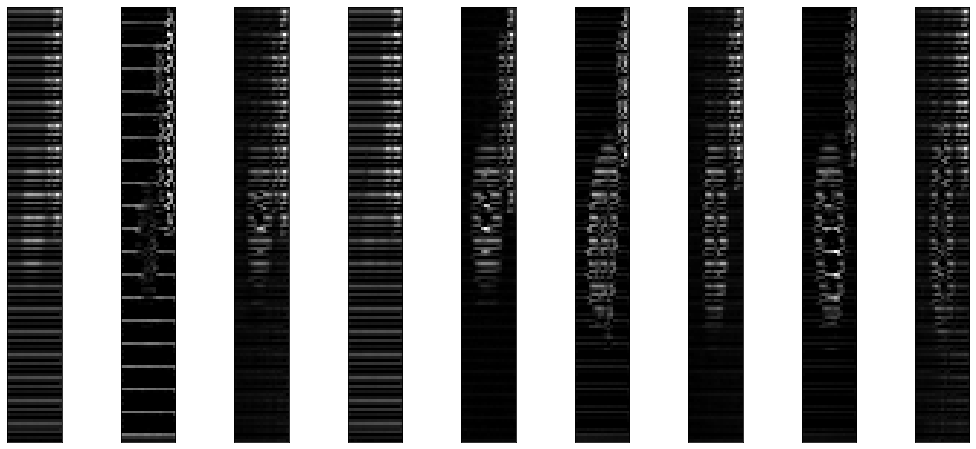

In [86]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(19, 19 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

run it on the labeled data to see where it puts stuff

In [87]:
x = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
x.shape

(20, 2888)

visualize in PCA

In [88]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(20, 3)

In [55]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [56]:
df = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], y_test]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df.head()

,pc1,pc2,pc3,label
0,-3.600296,0.919991,1.130366,7.0
1,0.814828,0.935140,-1.527937,2.0
2,-7.712289,-1.635274,-0.238859,1.0
3,5.295169,0.269643,-0.483024,0.0
4,-1.326154,1.638972,2.899503,4.0


In [89]:
df = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2]]).T, 
                  columns=['pc1', 'pc2', 'pc3'])
df.head()

,pc1,pc2,pc3
0,-9.527860,9.796672,-9.718730
1,-40.082031,-6.419348,-0.813327
2,48.248394,-29.828590,20.129133
3,-1.745885,1.561586,-18.212387
4,-31.893726,-16.423235,1.487487


In [57]:
import plotly.express as px
fig = px.scatter_3d(df.sample(1000), x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [91]:
import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3')
fig.show()